In [ ]:
import sys
import os
import asyncio
from pprint import pprint
from random import randrange
import pandas as pd
import logging
import hashlib
import re
import math

from river import anomaly
import os
import pathlib

sys.path.append ('..')
import utils

project_path = os.path.join('..', '..', 'scale')

sys.path.append(project_path)

utils.add_to_sys_path(project_path)

#from scale.backends.tempo_client import TempoClient

## Spans dataset directory

In [2]:
SPANS_CSV_DIR = os.path.join('..', 'data', 'spans')

os.path.exists(SPANS_CSV_DIR)

True

## Parameters

### Dataset to use

In [3]:
dataset = "spans_tracemesh_style_11_11.csv"
# dataset = "spans_11_7.csv"

### Testing and Tuning Parameters

In [4]:
# A fixed amount of milliseconds to add to a shocked duration
shock_static_bump=10

# A range that is used to pick a factor from to multiply a shocked duration by
shock_range=(8, 10)

# The number of bits to use from a hashed operation name to perform binary encoding
feature_length=64         

# The maximum duration a span can have to be considered for training
max_train_duration=10000

# The maximum duration a span can have when scoring (if higher, it will be capped at this)
max_duration=10000

# The minimum score with [0, 1] that will signify a trace as anomalous
sample_score=0.60

# Parameter to HST for number of trees to use
n_trees=16

# Height of each tree. Note that a tree of height `h` is made up of `h + 1` levels and
# therefore contains `2 ** (h + 1) - 1` nodes.
height=8
            
# Number of observations to use for calculating the mass at each node in each tree.
window_size=175

# Switch between pulling traces from a CSV or from Tempo
df_source="csv"

# URL if pulling from Tempo
tempo_url="http://localhost:32000"

# Path to CSV if pulling from CSV
csv_path=os.path.join(SPANS_CSV_DIR, dataset)

# Featurize method for classifying service/operation - currently support = [binenc, onehot]
featurizer_type = "onehot"

## Methods

### Removes unique text form operations

In [5]:
SANITIZE_PATTERNS = [
    re.compile("(GET .*)\\?.*"),
    re.compile("(GET /api/products)/[A-Z0-9]+"),
]

def sanitize_operation(operation):
    for pattern in SANITIZE_PATTERNS:
        operation = pattern.sub("\\1", operation)
    return operation

In [6]:
def normalize_duration(duration, max_duration):
    return min(duration, max_duration)

## Featurize Operation

Generates unique features set for each operation

In [7]:
if featurizer_type == "binenc":
    def featurize(service, operation):
        name = service + sanitize_operation(operation)
        hash_object = hashlib.sha256(name.encode())
        hash_value = int.from_bytes(hash_object.digest(), "big")
        features = {str(i): hash_value & (1 << i) for i in range(feature_length)}
        return features
elif featurizer_type == "onehot":
    service_encodings = {}
    operation_encodings = {}
    def featurize(service, operation):
        operation = sanitize_operation(operation)
        service_encoding = service_encodings.get(service)
        if service_encoding is None:
            service_encodings[service] = service_encoding = len(service_encodings)
        operation_encoding = operation_encodings.get(operation)
        if operation_encoding is None:
            operation_encodings[operation] = operation_encoding = len(operation_encodings)
        features = {f"s{service_encoding}": 1, f"o{operation_encoding}": 1}
        return features
else:
    raise Exception(f"Invalid featurizer_type: {featurizer_type}")

## Load the dataset

Load the pandas dataframe, trimming exceedingly out of range values

In [8]:
spans_df = pd.read_csv(csv_path)

if "OperationName" in spans_df.columns:
    # tracemesh style
    spans_df['duration'] = spans_df['Duration']
    spans_df['service_name'] = spans_df['OperationName']
    spans_df['name'] = spans_df['OperationName']
    spans_df['span_id'] = spans_df['SpanID']
else:
    # normal style
    spans_df['duration'] = 1e-6 * (spans_df['end_time_unix_nano'] - spans_df['start_time_unix_nano'])

spans_df = spans_df[spans_df["duration"] < max_train_duration]
len(spans_df)

77210

## Prepare the training, test, and control datasets

In [9]:
train_pct = 0.15
control_pct = 0.5
shock_pct = 0.03

train_size = int(len(spans_df) * train_pct)
control_size = int(len(spans_df) * control_pct)
shock_test_size = int(len(spans_df) * shock_pct)

train_df = spans_df.sample(n=train_size)

# Remove the training spans from the original dataframe
spans_df = spans_df[~spans_df.index.isin(train_df.index)]

control_df = spans_df.sample(n=control_size)

# Remove the control spans
spans_df = spans_df[~spans_df.index.isin(control_df.index)]

shock_test_df = spans_df.sample(n=shock_test_size)

# Remove the shock test spans
spans_df = spans_df[~spans_df.index.isin(shock_test_df.index)]

print(f"Training size: {len(train_df)}")
print(f"Control size: {len(control_df)}")
print(f"Shock test size: {len(shock_test_df)}")
print(f"Remaining spans: {len(spans_df)}")

Training size: 11581
Control size: 38605
Shock test size: 2316
Remaining spans: 24708


## Prepare the model

In [10]:
limits = {"dur": (0, max_duration)}

test_results = []

hst = anomaly.HalfSpaceTrees(
    n_trees=n_trees, 
    height=height, 
    window_size=window_size, 
    seed=895, 
    limits=limits
)

## Train the model

In [11]:
# Train model
for index, span in train_df.iterrows():
    service = span["service_name"]
    operation = span["name"]
    record = featurize(service, operation)
    duration = span["duration"]
    record["dur"] = normalize_duration(duration, max_duration)
    hst.learn_one(record)

## Record hits for test set

In [12]:
import time
## Record hits for shocked spans
shock_hits = []

shock_time = 0
for index, span in shock_test_df.iterrows():
    start_time = time.time()
    shock_factor = randrange(*shock_range)
    service = span["service_name"]
    operation = span["name"]
    record = featurize(service, operation)
    duration = (span["duration"] + shock_static_bump) * shock_factor
    record["dur"] = normalize_duration(duration, max_duration)
    score = hst.score_one(record)
    shock_time += time.time() - start_time

    test_results.append({
        "span_id": span["span_id"],
        "duration": span["duration"],
        "shock_factor": shock_factor,
        "score": score,
        "label": 1,
    })
    if score > sample_score:
        shock_hits.append(span["span_id"])

print(f"total time: {shock_time}")
time_per_span_shocked = shock_time / len(shock_test_df)
print(f"Time per span: {time_per_span_shocked:.6f} seconds")

total time: 0.11485934257507324
Time per span: 0.000050 seconds


## Record hits for control group

In [13]:
# Record hits for unshocked spans
false_positives = []
control_time = 0
for index, span in control_df.iterrows():
    start_time = time.time()
    service = span["service_name"]
    operation = span["name"]
    record = featurize(service, operation)
    duration = span["duration"]
    record["dur"] = normalize_duration(duration, max_duration)
    score = hst.score_one(record)
    control_time += time.time() - start_time
    test_results.append({
        "span_id": span["span_id"],
        "duration": span["duration"],
        "shock_factor": 1,
        "score": score,
        "label": 0,
    })
    if score > sample_score:
        false_positives.append(span["span_id"])

print("total time: ", control_time)   

time_per_span_control = control_time / len(control_df)
print(f"Time per span: {time_per_span_control:.6f} seconds")


total time:  1.55845046043396
Time per span: 0.000040 seconds


---

## Report results

In [14]:
shock_rate = 100 * len(shock_hits) / len(shock_test_df)
total_rate = 100 * len(false_positives) / len(control_df)
results_df = pd.DataFrame(test_results)
print(f"Shocked hit on {round(shock_rate, 3)}%")
print(f"False positives hit on {round(total_rate, 3)}%")
print(f"Total spans processed: {len(shock_test_df) + len(control_df)}")
print(f"Average time per span: {round((time_per_span_shocked + time_per_span_control) / 2, 4)} seconds")
print(f"Spans processed per second: {round(1 / ((time_per_span_shocked + time_per_span_control) / 2), 4)}")

Shocked hit on 100.0%
False positives hit on 2.645%
Total spans processed: 40921
Average time per span: 0.0 seconds
Spans processed per second: 22231.367


In [15]:
## Parameter Tuning Through Grid Search

import itertools

# Define the ranges for each parameter you want to tune
n_trees_values = [12, 16, 32]            # Example values for number of trees
height_values = [8, 10, 12]              # Example values for height of each tree
window_size_values = [125, 175, 250]     # Example values for window size
feature_length_values = [16, 32, 64]     # Example values for hashing operation
shock_range_values = [(8, 10), (10, 15), (15,20)]  # Example ranges for shock factor
shock_static_bump_values = [5, 10, 15]   # Example static bump values for shocked durations
sample_score_values = [0.4, 0.5, 0.6]   # Example anomaly score thresholds

# Keep track of the best parameter combination and performance
best_params = None
best_shock_detection_rate = 0
best_false_positive_rate = 100
desired_detection_rate = 100.0  # We want 100% detection of shocked spans
desired_false_positive_rate = 1.0  # We want less than 1% false positives

# Iterate over each combination of parameter values
for n_trees, height, window_size, feature_length, shock_range_val, shock_static_bump_val, sample_score_val in itertools.product(
    n_trees_values,
    height_values,
    window_size_values,
    feature_length_values,
    shock_range_values,
    shock_static_bump_values,
    sample_score_values
):
    # Print the parameter combination being tested
    print(f"Testing combination: n_trees={n_trees}, height={height}, window_size={window_size}, "
          f"feature_length={feature_length}, shock_range={shock_range_val}, shock_static_bump={shock_static_bump_val}, "
          f"sample_score={sample_score_val}")

    # Reinitialize and retrain the model with the current parameter combination
    # Prepare the model with the current parameters
    hst = anomaly.HalfSpaceTrees(
        n_trees=n_trees,
        height=height,
        window_size=window_size,
        seed=895,
        limits={"dur": (0, max_duration)}
    )
    
    # Train the model on the training set
    for _, span in train_df.iterrows():
        service = span["service_name"]
        operation = span["name"]
        record = featurize(service, operation)
        duration = span["duration"]
        record["dur"] = normalize_duration(duration, max_duration)
        hst.learn_one(record)

    # Evaluate on shocked test set
    shocked_scores = []
    for _, span in shock_test_df.iterrows():
        service = span["service_name"]
        operation = span["name"]
        record = featurize(service, operation)
        # Apply shock factor to duration
        shock_factor = randrange(*shock_range_val)
        duration = (span["duration"] + shock_static_bump_val) * shock_factor
        record["dur"] = normalize_duration(duration, max_duration)
        score = hst.score_one(record)
        shocked_scores.append(score)

    shock_hits = [score for score in shocked_scores if score >= sample_score_val]
    shock_detection_rate = 100 * len(shock_hits) / len(shock_test_df)
    
    # Evaluate on control set
    control_scores = []
    for _, span in control_df.iterrows():
        service = span["service_name"]
        operation = span["name"]
        record = featurize(service, operation)
        duration = span["duration"]
        record["dur"] = normalize_duration(duration, max_duration)
        score = hst.score_one(record)
        control_scores.append(score)

    false_positives = [score for score in control_scores if score >= sample_score_val]
    false_positive_rate = 100 * len(false_positives) / len(control_df)

    # Print the performance for this parameter combination
    print(f" - Shocked detection rate: {shock_detection_rate:.2f}%")
    print(f" - False positive rate: {false_positive_rate:.2f}%\n")

    # Check if this combination meets desired criteria and update best parameters if needed
    if shock_detection_rate >= best_shock_detection_rate and false_positive_rate < best_false_positive_rate:
        best_params = {
            "n_trees": n_trees,
            "height": height,
            "window_size": window_size,
            "feature_length": feature_length,
            "shock_range": shock_range_val,
            "shock_static_bump": shock_static_bump_val,
            "sample_score": sample_score_val,
            "shock_detection_rate": shock_detection_rate,
            "false_positive_rate": false_positive_rate,
        }
        best_shock_detection_rate = shock_detection_rate
        best_false_positive_rate = false_positive_rate

    # Early stopping if the desired criteria are met exactly
    if shock_detection_rate == desired_detection_rate and false_positive_rate <= desired_false_positive_rate:
        break

# After testing all combinations, print the best parameters found
if best_params is not None:
    print("### Best Parameter Combination Found ###")
    for key, value in best_params.items():
        print(f"{key}: {value}")
else:
    print("No parameter combination was found that meets the desired criteria.")


Testing combination: n_trees=12, height=8, window_size=125, feature_length=16, shock_range=(8, 10), shock_static_bump=5, sample_score=0.4
 - Shocked detection rate: 100.00%
 - False positive rate: 6.16%

Testing combination: n_trees=12, height=8, window_size=125, feature_length=16, shock_range=(8, 10), shock_static_bump=5, sample_score=0.5
 - Shocked detection rate: 100.00%
 - False positive rate: 5.08%

Testing combination: n_trees=12, height=8, window_size=125, feature_length=16, shock_range=(8, 10), shock_static_bump=5, sample_score=0.6
 - Shocked detection rate: 94.08%
 - False positive rate: 3.48%

Testing combination: n_trees=12, height=8, window_size=125, feature_length=16, shock_range=(8, 10), shock_static_bump=10, sample_score=0.4
 - Shocked detection rate: 100.00%
 - False positive rate: 6.16%

Testing combination: n_trees=12, height=8, window_size=125, feature_length=16, shock_range=(8, 10), shock_static_bump=10, sample_score=0.5
 - Shocked detection rate: 100.00%
 - False p

KeyboardInterrupt: 

---

## Score Distribution for Shocked and Unshocked Spans

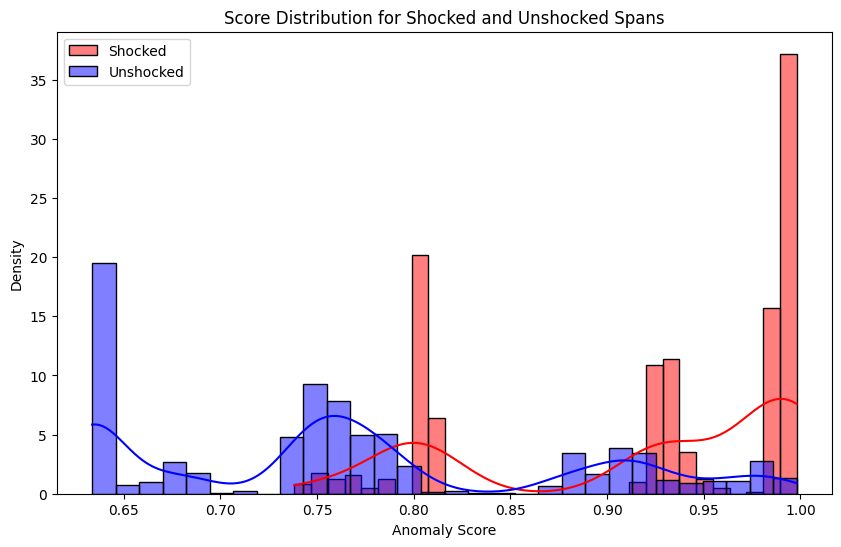

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.histplot(results_df[results_df["label"] == 1]["score"], color='red', label='Shocked', kde=True, stat='density', bins=30)
sns.histplot(results_df[results_df["label"] == 0]["score"], color='blue', label='Unshocked', kde=True, stat='density', bins=30)
plt.xlabel('Anomaly Score')
plt.title('Score Distribution for Shocked and Unshocked Spans')
plt.legend()
plt.show()



Precision-Recall



## Precision-Recall Curve

Shows how well our model can detect anomalies versus normal behavior at different thresholds


Precision = TP / (TP + FP)

Recall = TP / (TP + FN)


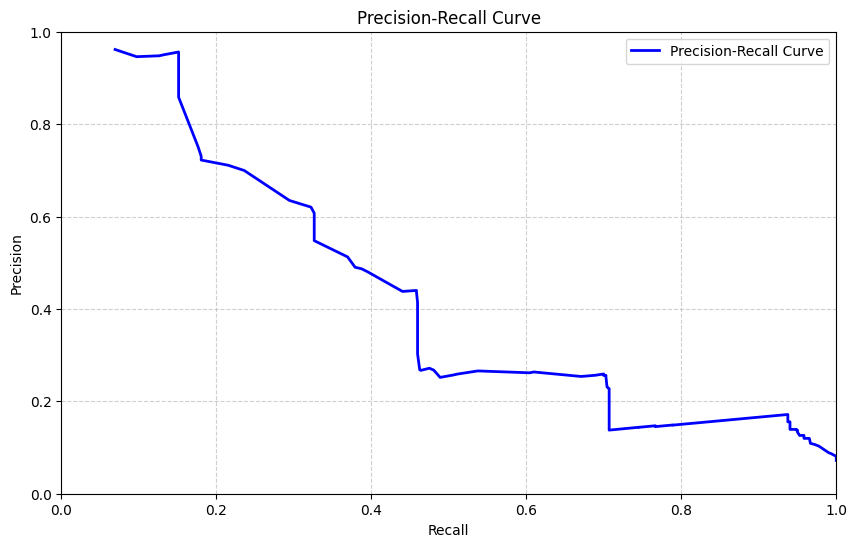

In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Calculate precision and recall for different thresholds
precision, recall, thresholds = precision_recall_curve(results_df["label"], results_df["score"])

precision = precision[1:-1]
recall = recall[1:-1]

plt.figure(figsize=(10, 6))
plt.plot(recall, precision, color='blue', linewidth=2, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()



## Confusion Matrix Plot

True Negatives (top-left)

False Positives (top-right)

False Negatives (bottom-left)

True Positives (bottom-right)


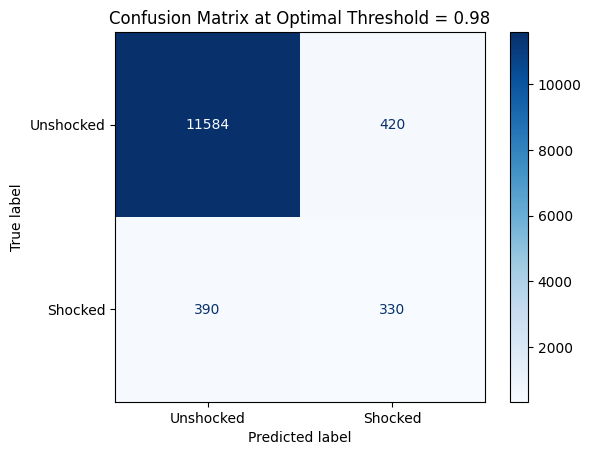

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
import numpy as np

f1s = []

for thresh in thresholds:
    # Generate predictions based on the current threshold and calculate F1 score
    predictions = [1 if score >= thresh else 0 for score in results_df["score"]]
    f1s.append(f1_score(results_df["label"], predictions))

optimal_threshold = thresholds[np.argmax(f1s)]
predictions = [1 if score >= optimal_threshold else 0 for score in results_df["score"]]

cm = confusion_matrix(results_df["label"], predictions)
ConfusionMatrixDisplay(cm, display_labels=["Unshocked", "Shocked"]).plot(cmap='Blues')
plt.title(f'Confusion Matrix at Optimal Threshold = {optimal_threshold:.2f}')
plt.show()

